# Predicting Netflix Shows Rating

In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# feature selection / hyperparameter
from sklearn.feature_selection import f_regression, SelectKBest
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV

# regression models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
 
# regression error metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings("ignore")

# **Problem Statement**
---

* Netflix is a streaming platform for various types of content in different languages. The goal is to help Netflix identify what kind of content they should produce that will result in higher ratings, which is the target variable. If Netflix has content with high ratings that users want to watch, they need a model to help identify what content to stream. 

## **About the Dataset**

---
 
- Contains the list and metadata of all TV Shows and Movies available on Netflix in June 2021.
- 19 columns & 7008 rows
- Target variable : average rating given to the show
- Variables : title, popular_rank, startYear, endYear, episodes, type, orign_country, runtime, language, summary, genres, cast, etc.

Data Source
       - Link to dataset: https://www.kaggle.com/snehaanbhawal/netflix-tv-shows-and-movie-list


In [2]:
df = pd.read_csv('netflix_list.csv')
print(df.shape)
df.head()

(7008, 19)


,imdb_id,title,popular_rank,certificate,startYear,endYear,episodes,runtime,type,orign_country,language,plot,summary,rating,numVotes,genres,isAdult,cast,image_url
0,tt4052886,Lucifer,1,15,2016.0,NaN,93.0,42,tvSeries,United States,English,Lucifer Morningstar has decided he's had enoug...,"Lucifer Morningstar, bored from his sulking li...",8.1,250884.0,"Crime,Drama,Fantasy",0,"['Tom Ellis', 'Lauren German', 'Lesley-Ann Bra...",https://m.media-amazon.com/images/M/MV5BNzY1Yj...
1,tt0993840,Army of the Dead,2,18,2021.0,NaN,NaN,148,movie,United States,English,"Following a zombie outbreak in Las Vegas, a gr...","With the abandoned, walled city of Las Vegas o...",5.8,110780.0,"Action,Crime,Horror",0,"['Dave Bautista', 'Ella Purnell', 'Ana de la R...",https://m.media-amazon.com/images/M/MV5BNGY0Nz...
2,tt7255502,The Kominsky Method,3,18,2018.0,2021.0,22.0,30,tvSeries,United States,English,"An aging actor, who long ago enjoyed a brush w...",Michael Douglas plays an actor who made it big...,8.2,28795.0,"Comedy,Drama",0,"['Michael Douglas', 'Sarah Baker', 'Graham Rog...",https://m.media-amazon.com/images/M/MV5BMzA0YT...
3,tt0108778,Friends,4,13+,1994.0,2004.0,235.0,22,tvSeries,United States,English,Follows the personal and professional lives of...,"Ross Geller, Rachel Green, Monica Geller, Joey...",8.9,861843.0,"Comedy,Romance",0,"['Jennifer Aniston', 'Courteney Cox', 'Lisa Ku...",https://m.media-amazon.com/images/M/MV5BNDVkYj...
4,tt9251798,Ragnarok,5,18,2020.0,NaN,12.0,45,tvSeries,Norway,Norwegian,A small Norwegian town experiencing warm winte...,In the small fictional town of Edda coming of ...,7.5,26606.0,"Action,Drama,Fantasy",0,"['David Stakston', 'Jonas Strand Gravli', 'Her...",https://m.media-amazon.com/images/M/MV5BODM3NT...


**Data Description**

---



* IMDB ID: Unique ID for each show
* Title: Name of the show
* Popular Rank: Rank among all shows
* Certificate: Age Recommendation
* Start Year: Launch Year of show
* End Year: Last Episode published
* Episodes: Number of episodes
* Type: Category of show- movie/series etc
* Runtime: View hours
* Origin Country: Native production country
* Language: Original Language 
* Plot: Story background relevance
* Summary: Essence of the entire show
* Rating: Target variable which explains what is the rating a show received
* Num Votes: Number of votes received from people
* Genres: Classification of  based on content of show
* Cast: Artists who acted in the show


In [3]:
# not informative variables
df.drop(['imdb_id', 'title', 'image_url'], axis=1, inplace=True)

# Data Preparation

## Removing Target Variables

When we predict ratings, we don't have data regarding Popular Rank and Num Votes. They are target leakages so we can remove them. Also, casting information may not be usable in the future because they may retire or die over time. We won't use it. 

In [4]:
df.drop(['popular_rank', 'numVotes', 'cast'], axis=1, inplace=True)

## Dealing with missing values

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7008 entries, 0 to 7007
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   certificate    2409 non-null   object 
 1   startYear      6493 non-null   float64
 2   endYear        1126 non-null   float64
 3   episodes       2304 non-null   float64
 4   runtime        7006 non-null   object 
 5   type           7006 non-null   object 
 6   orign_country  7008 non-null   object 
 7   language       7008 non-null   object 
 8   plot           6609 non-null   object 
 9   summary        7008 non-null   object 
 10  rating         6000 non-null   float64
 11  genres         7006 non-null   object 
 12  isAdult        7008 non-null   int64  
dtypes: float64(4), int64(1), object(8)
memory usage: 711.9+ KB


In [6]:
# figure out columns containing missing values above 30%
num_missing = df.isnull().sum()
missing_cols = num_missing[num_missing > len(df)*0.3].index
print(missing_cols)

Index(['certificate', 'endYear', 'episodes'], dtype='object')


In [7]:
df.drop(['certificate', 'endYear', 'episodes'], axis=1, inplace=True)

In [8]:
# remove rows where target vriable is null
df = df[df['rating'].notnull()]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 7007
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   startYear      6000 non-null   float64
 1   runtime        6000 non-null   object 
 2   type           6000 non-null   object 
 3   orign_country  6000 non-null   object 
 4   language       6000 non-null   object 
 5   plot           5837 non-null   object 
 6   summary        6000 non-null   object 
 7   rating         6000 non-null   float64
 8   genres         6000 non-null   object 
 9   isAdult        6000 non-null   int64  
dtypes: float64(2), int64(1), object(7)
memory usage: 515.6+ KB


We are not going to use the text 'plot' column because it's similar to summary column. 

In [10]:
df.drop('plot', axis=1, inplace=True)

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6000 entries, 0 to 7007
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   startYear      6000 non-null   float64
 1   runtime        6000 non-null   object 
 2   type           6000 non-null   object 
 3   orign_country  6000 non-null   object 
 4   language       6000 non-null   object 
 5   summary        6000 non-null   object 
 6   rating         6000 non-null   float64
 7   genres         6000 non-null   object 
 8   isAdult        6000 non-null   int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 468.8+ KB


In [12]:
df.head()

,startYear,runtime,type,orign_country,language,summary,rating,genres,isAdult
0,2016.0,42,tvSeries,United States,English,"Lucifer Morningstar, bored from his sulking li...",8.1,"Crime,Drama,Fantasy",0
1,2021.0,148,movie,United States,English,"With the abandoned, walled city of Las Vegas o...",5.8,"Action,Crime,Horror",0
2,2018.0,30,tvSeries,United States,English,Michael Douglas plays an actor who made it big...,8.2,"Comedy,Drama",0
3,1994.0,22,tvSeries,United States,English,"Ross Geller, Rachel Green, Monica Geller, Joey...",8.9,"Comedy,Romance",0
4,2020.0,45,tvSeries,Norway,Norwegian,In the small fictional town of Edda coming of ...,7.5,"Action,Drama,Fantasy",0


## Feature Engineering

### Dealing with zero variance predictor or too many categories

Let's remove zero variance predictor 'isAdult' and reduce the numbers of categories in each categorical variable. 

In [13]:
cate_col = ['startYear', 'type', 'orign_country', 'language', 'isAdult']

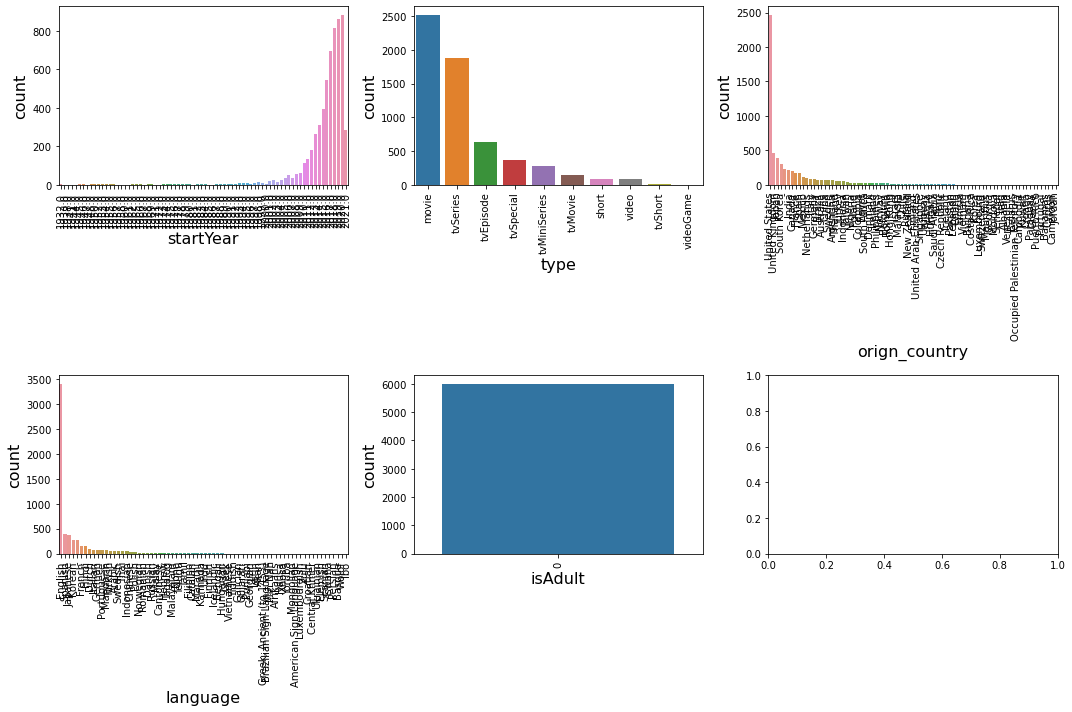

In [14]:
import math
fig, axes = plt.subplots(figsize=(15,10),nrows=2, ncols=3)
for i, col in enumerate(cate_col):
    count = df[col].value_counts()
    count = pd.DataFrame(count)
    r = int(math.floor(i/3))
    k = i % 3
    sns.barplot(ax=axes[r, k], data=count, x=count.index, y=count[col])
    axes[r, k].set_xlabel(col, fontsize=16) # x label
    axes[r, k].set_ylabel('count', fontsize=16) # y label
    axes[r, k].set_xticklabels(axes[r, k].get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

In [15]:
df.reset_index(drop=True, inplace=True)

In [16]:
# Grouping years into decases
df["startYear"] = pd.to_numeric(df["startYear"])

for i, v in enumerate(df['startYear']):
    if v < 1990:
        df['startYear'][i] = '~80s'
    elif (v >= 1990)&(v < 2000):
        df['startYear'][i] = '90s'
    elif (v >= 2000)&(v < 2010):
        df['startYear'][i] = '00s'
    elif (v >= 2010)&(v < 2020):
        df['startYear'][i] = '10s'
    elif v >= 2020:
        df['startYear'][i] = '20s'

In [17]:
df['startYear'].value_counts()

10s     4310
20s     1167
00s      335
~80s     107
90s       81
Name: startYear, dtype: int64

We noticed that there were many languages in the column. However, the outliers were English, Korean, and Spanish. We decided to leave the above-mentioned three in their own categories and combine the rest into an "others" column.

In [18]:
# Modifying the number of values in language column
df['language'].value_counts()

English     3400
Spanish      392
Japanese     366
Korean       281
-            279
            ... 
Tswana         1
Persian        1
Basque         1
Wolof          1
Ibo            1
Name: language, Length: 70, dtype: int64

In [19]:
# Modifying the number of values in language column
df.loc[(df['language'] != 'English') & (df['language'] != 'Korean') & (df['language'] != 'Spanish') & (df['language'] != 'Japanese'), 'language'] = 'Others' 

In [20]:
# Final number of language column
df['language'].value_counts()

English     3400
Others      1561
Spanish      392
Japanese     366
Korean       281
Name: language, dtype: int64

Similar to language, we decided to transform the origin country column as well.

In [21]:
# Modifying the number of values in orign_country column
df['orign_country'].value_counts()

United States     2467
United Kingdom     468
Japan              384
South Korea        295
-                  232
                  ... 
Portugal             1
Bahamas              1
Cyprus               1
Cameroon             1
Jordan               1
Name: orign_country, Length: 79, dtype: int64

In [22]:
# Modifying the number of values in orign_country column
df.loc[(df['orign_country'] != 'United States') & (df['orign_country'] != 'United Kingdom') & (df['orign_country'] != 'Japan') & (df['orign_country'] != 'South Korea') & (df['orign_country'] != 'India'), 'orign_country'] = 'Others' 

In [23]:
# Final number of origin_country values
df['orign_country'].value_counts()

United States     2467
Others            2165
United Kingdom     468
Japan              384
South Korea        295
India              221
Name: orign_country, dtype: int64

In [24]:
df['type'].value_counts()

movie           2517
tvSeries        1880
tvEpisode        639
tvSpecial        366
tvMiniSeries     277
tvMovie          147
short             85
video             83
tvShort            5
videoGame          1
Name: type, dtype: int64

In [25]:
# Modifying the number of values in type column
df.loc[(df['type'] == 'videoGame')|(df['type'] == 'tvShort')|(df['type'] == 'video')|(df['type'] == 'short')|(df['type'] == 'tvSpecial'), 'type'] = 'Others'
df.loc[(df['type'] == 'tvMovie'), 'type'] = 'movie'
df.loc[(df['type'] == 'tvMiniSeries'), 'type'] = 'tvSeries'

In [26]:
df['type'].value_counts()

movie        2664
tvSeries     2157
tvEpisode     639
Others        540
Name: type, dtype: int64

In [27]:
# remove zero variance predictor
df.drop('isAdult', axis=1, inplace=True)
cate_col.remove('isAdult')

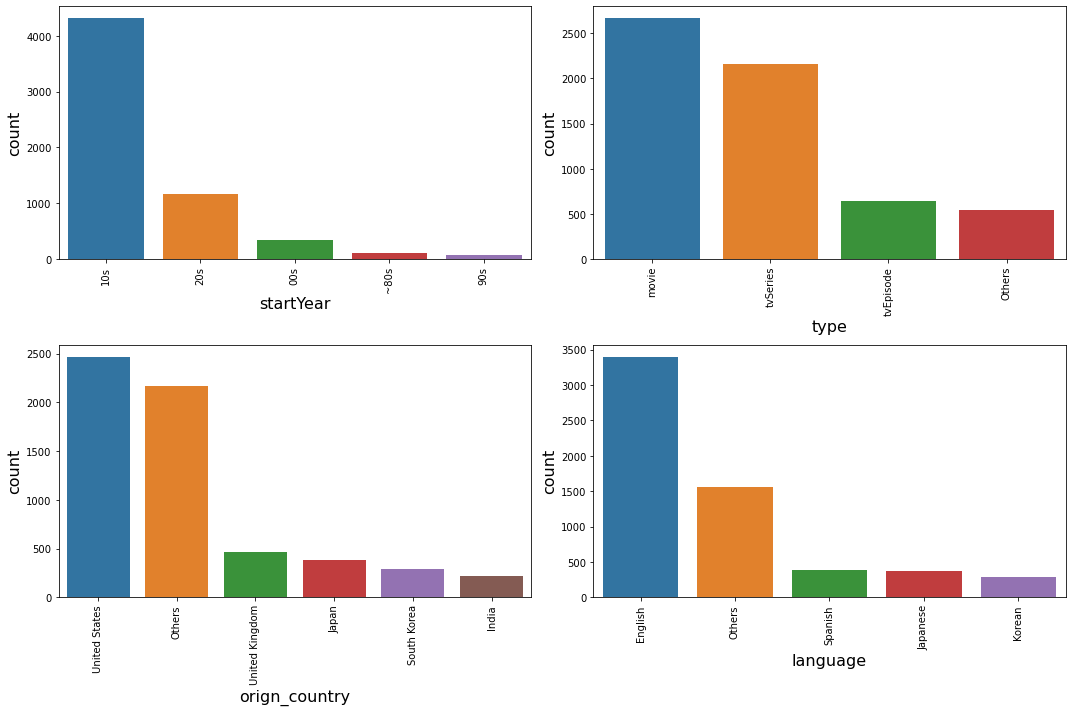

In [28]:
import math
fig, axes = plt.subplots(figsize=(15,10),nrows=2, ncols=2)
for i, col in enumerate(cate_col):
    count = df[col].value_counts()
    count = pd.DataFrame(count)
    r = int(math.floor(i/2))
    k = i % 2
    sns.barplot(ax=axes[r, k], data=count, x=count.index, y=count[col])
    axes[r, k].set_xlabel(col, fontsize=16) # x label
    axes[r, k].set_ylabel('count', fontsize=16) # y label
    axes[r, k].set_xticklabels(axes[r, k].get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

### Extracting meaningful information from string values

In [29]:
# unique genres
genre_list = []
for i in df['genres']:
    a = i.split(',')
    genre_list = genre_list + a

genre_uni = set(genre_list)
fre_genre = {}

for i in genre_uni:
    fre_genre[i] = genre_list.count(i)

fre_genre

{'Mystery': 437,
 'Reality-TV': 177,
 'Western': 22,
 'Musical': 42,
 '\\N': 14,
 'Short': 96,
 'Fantasy': 333,
 'History': 204,
 'Comedy': 1939,
 'Sport': 117,
 'Crime': 921,
 'News': 19,
 'Documentary': 946,
 'Biography': 253,
 'Family': 319,
 'Romance': 603,
 'War': 48,
 'Thriller': 576,
 'Talk-Show': 27,
 'Horror': 376,
 'Animation': 781,
 'Film-Noir': 11,
 'Sci-Fi': 204,
 'Game-Show': 34,
 'Action': 1044,
 'Adventure': 725,
 'Drama': 2490,
 'Music': 155}

We will classify the genres which have less than 200 rows into 'others'.

In [30]:
genre_main = ['Sci-Fi', 'Biography', 'Drama', 'Adventure', 'Mystery', 'Action', 'History', 'Crime', 'Documentary', 'Animation',
             'Romance', 'Family', 'Comedy', 'Fantasy', 'Horror', 'Thriller']

for genre in genre_main:
    df[genre] = 0

In [31]:
df['genre_others'] = 0

In [32]:
df[['genre_1', 'genre_2', 'genre_3']] = df['genres'].str.split(',', expand=True)

In [33]:
for i, genre in enumerate(df['genre_1']):
    if genre in genre_main:
        df[genre][i] = 1
    elif genre == None:
        continue
    else:
        df['genre_others'][i] = 1
        
for i, genre in enumerate(df['genre_2']):
    if genre in genre_main:
        df[genre][i] = 1
    elif genre == None:
        continue
    else:
        df['genre_others'][i] = 1  

for i, genre in enumerate(df['genre_3']):
    if genre in genre_main:
        df[genre][i] = 1
    elif genre == None:
        continue
    else:
        df['genre_others'][i] = 1  

In [34]:
df.drop(['genres', 'genre_1', 'genre_2', 'genre_3'], axis=1, inplace=True)
df.head()

,startYear,runtime,type,orign_country,language,summary,rating,Sci-Fi,Biography,Drama,...,Crime,Documentary,Animation,Romance,Family,Comedy,Fantasy,Horror,Thriller,genre_others
0,10s,42,tvSeries,United States,English,"Lucifer Morningstar, bored from his sulking li...",8.1,0,0,1,...,1,0,0,0,0,0,1,0,0,0
1,20s,148,movie,United States,English,"With the abandoned, walled city of Las Vegas o...",5.8,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,10s,30,tvSeries,United States,English,Michael Douglas plays an actor who made it big...,8.2,0,0,1,...,0,0,0,0,0,1,0,0,0,0
3,90s,22,tvSeries,United States,English,"Ross Geller, Rachel Green, Monica Geller, Joey...",8.9,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,20s,45,tvSeries,Others,Others,In the small fictional town of Edda coming of ...,7.5,0,0,1,...,0,0,0,0,0,0,1,0,0,0


# Exploratory Data Analysis

## Categorical Variables

In [35]:
df.columns

Index(['startYear', 'runtime', 'type', 'orign_country', 'language', 'summary',
       'rating', 'Sci-Fi', 'Biography', 'Drama', 'Adventure', 'Mystery',
       'Action', 'History', 'Crime', 'Documentary', 'Animation', 'Romance',
       'Family', 'Comedy', 'Fantasy', 'Horror', 'Thriller', 'genre_others'],
      dtype='object')

In [36]:
cate_col = ['startYear', 'type', 'orign_country', 'language', 'Sci-Fi', 'Biography', 'Drama', 'Adventure', 
            'Mystery', 'Action', 'History', 'Crime', 'Documentary', 'Animation', 'Romance', 'Family', 'Comedy', 
            'Fantasy', 'Horror', 'Thriller', 'genre_others']

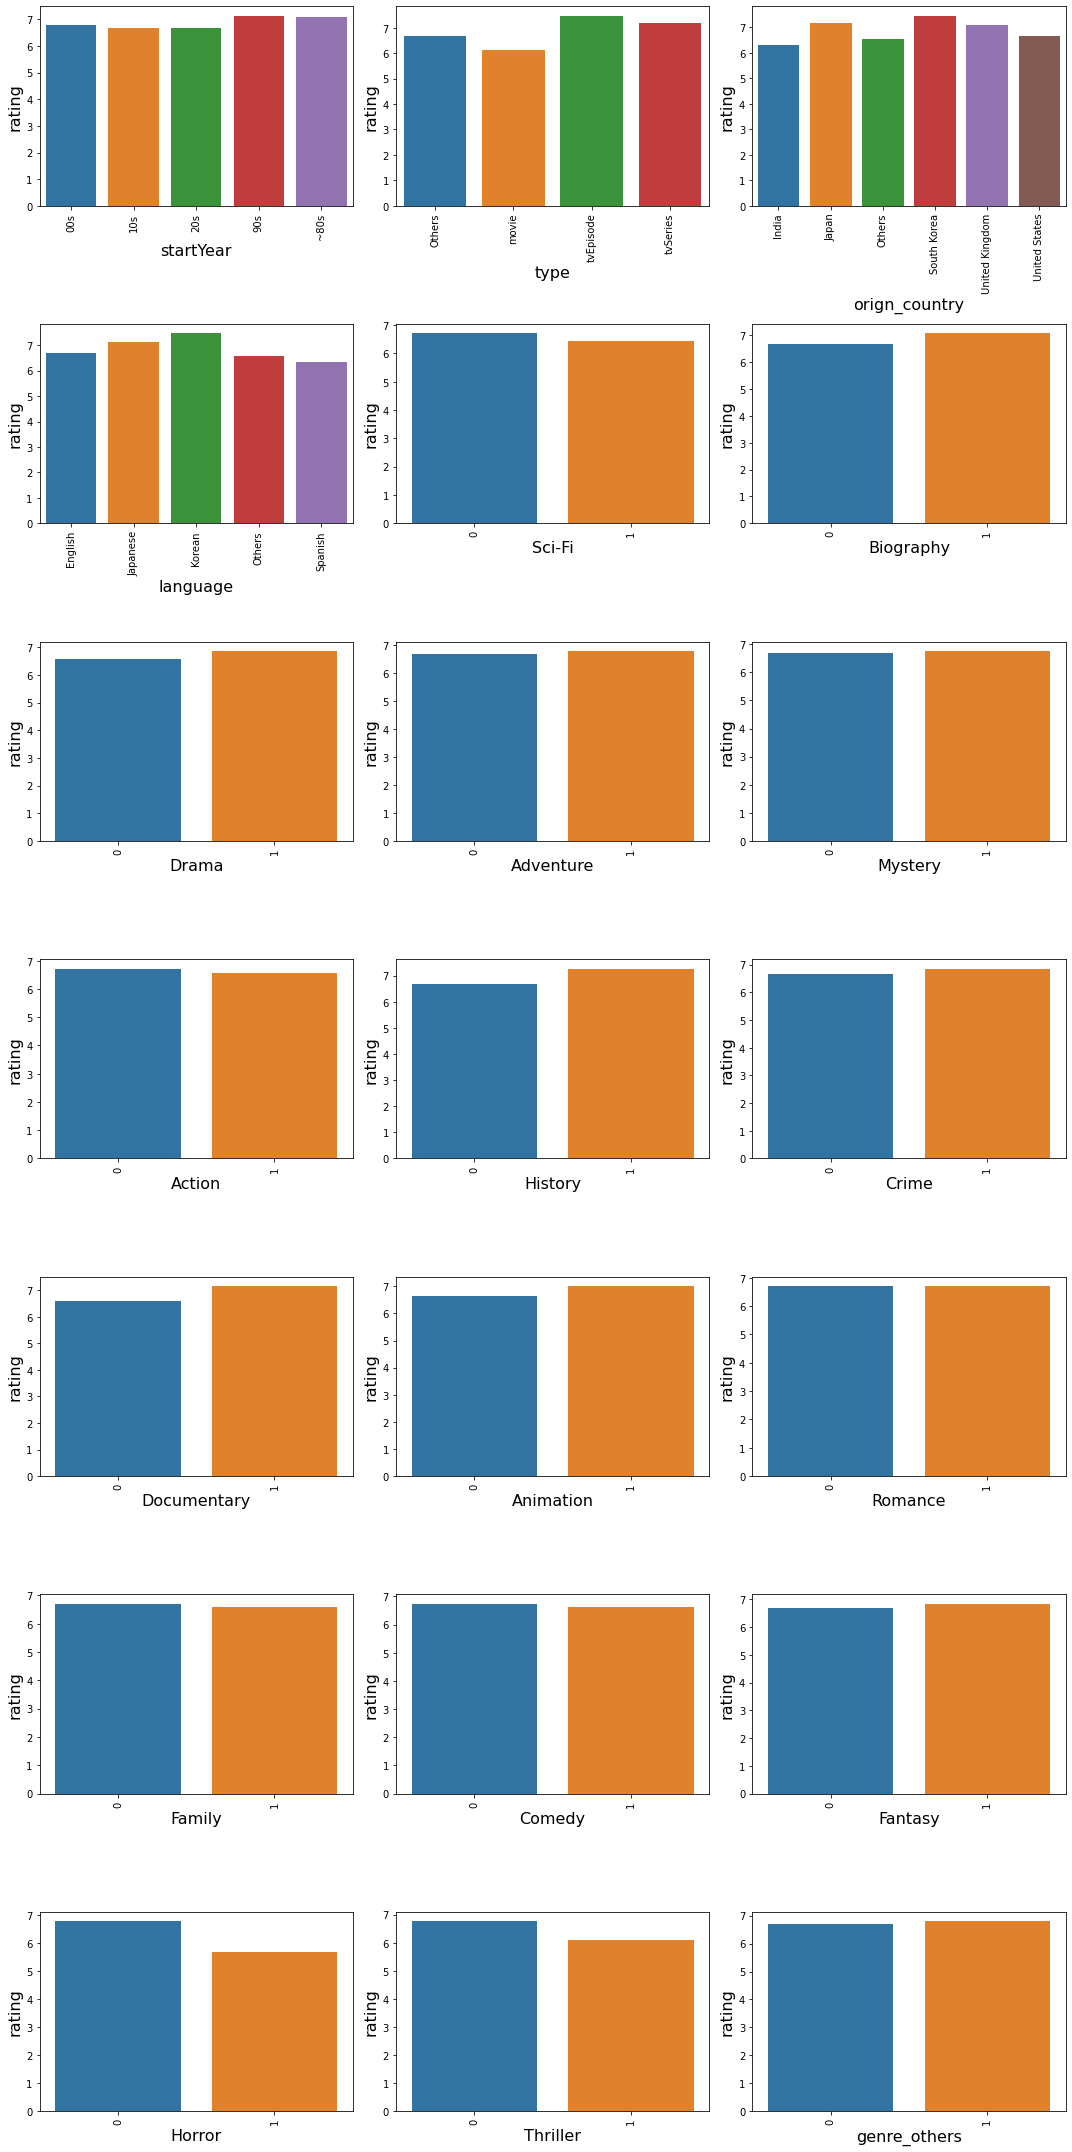

In [37]:
import math
fig, axes = plt.subplots(figsize=(15,30),nrows=7, ncols=3)
for i, col in enumerate(cate_col):
    mean = df.groupby(col)['rating'].mean()
    mean = pd.DataFrame(mean)
    r = int(math.floor(i/3))
    k = i % 3
    sns.barplot(ax=axes[r, k], data=mean, x=mean.index, y=mean['rating'])
    axes[r, k].set_xlabel(col, fontsize=16) # x label
    axes[r, k].set_ylabel('rating', fontsize=16) # y label
    axes[r, k].set_xticklabels(axes[r, k].get_xticklabels(), rotation=90)
plt.tight_layout()
plt.show()

#### Release Year
The older contents are more likely to have higher ratings. This makes sense because it's easy to choose masterpieces from older contents because they have been rated by many people over time. 

#### Type
We can see TV Episode and TV Series have higher ratings. 

#### Origin Country
The average rating of contents from South Korea is the highest followed by contents from Japan and the United Kingdom. 

#### Language
The average rating of contents in Korean is the highest followed by contents in Japanese and English.

#### Genres
The genres 'history' and 'biography' have relatively higher ratings, while 'horror' and 'thriller' have lower ratings. Historical or real stories usually touch people's hearts so they might give them ratings generously. On the other hand, 'horror' and 'thriller' terrify people so they might not be happy about the movies, thereby giving lower ratings.     

### Feature Selection - ANOVA or f-test

In [38]:
df_copy = df.copy()

In [39]:
from sklearn.preprocessing import LabelEncoder
class_le = LabelEncoder()

for col in cate_col:
    df_copy[col] = class_le.fit_transform(df_copy[col].values)

In [40]:
anova = f_regression(df_copy[cate_col], df_copy["rating"])
anova

(array([3.94477574e+00, 8.29456973e+02, 1.99490633e+00, 1.77980550e+01,
        9.23132195e+00, 2.50170332e+01, 8.65191989e+01, 4.83056608e+00,
        1.30073826e+00, 1.11519521e+01, 4.78579838e+01, 1.91273673e+01,
        1.68385613e+02, 5.89328971e+01, 2.63118273e-02, 3.29369102e+00,
        1.47477858e+01, 4.74014333e+00, 3.00998101e+02, 1.58726722e+02,
        5.23621956e+00]),
 array([4.70625632e-002, 5.87287313e-171, 1.57880705e-001, 2.49254285e-005,
        2.38934022e-003, 5.84433875e-007, 1.89846054e-020, 2.79975306e-002,
        2.54123953e-001, 8.44554256e-004, 5.05872602e-012, 1.24347985e-005,
        5.39026124e-038, 1.89291903e-014, 8.71146573e-001, 6.95964468e-002,
        1.24158106e-004, 2.95054718e-002, 7.90786022e-066, 6.10480471e-036,
        2.21559180e-002]))

<AxesSubplot:>

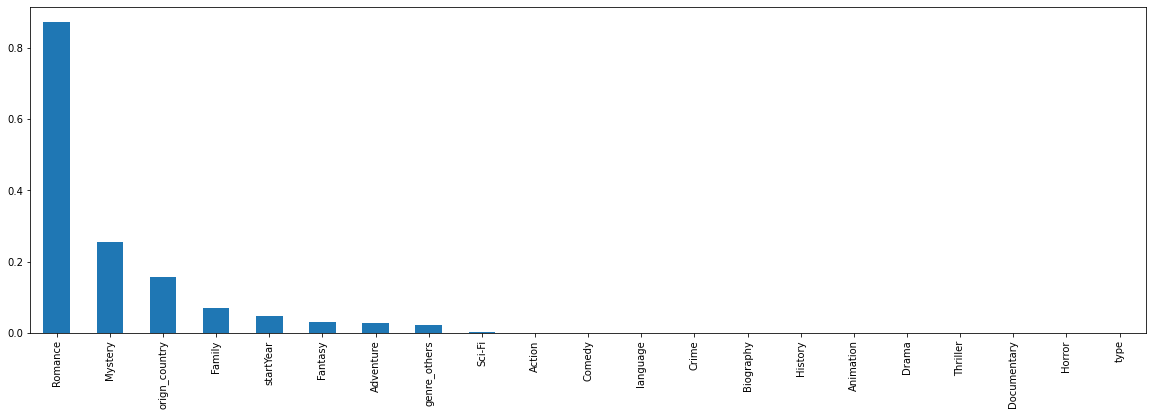

In [41]:
anova = pd.Series(anova[1])
anova.index = df_copy[cate_col].columns
anova.sort_values(ascending=False).plot.bar(figsize=(20, 6))

The p-value for origin_country is larger than 0.05, which is significant level so we will not use it for models. 

In [42]:
df.drop('orign_country', axis=1, inplace=True)
df.head()

,startYear,runtime,type,language,summary,rating,Sci-Fi,Biography,Drama,Adventure,...,Crime,Documentary,Animation,Romance,Family,Comedy,Fantasy,Horror,Thriller,genre_others
0,10s,42,tvSeries,English,"Lucifer Morningstar, bored from his sulking li...",8.1,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
1,20s,148,movie,English,"With the abandoned, walled city of Las Vegas o...",5.8,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,10s,30,tvSeries,English,Michael Douglas plays an actor who made it big...,8.2,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,90s,22,tvSeries,English,"Ross Geller, Rachel Green, Monica Geller, Joey...",8.9,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,20s,45,tvSeries,Others,In the small fictional town of Edda coming of ...,7.5,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


## Numeric Variables

There are many missing values in the 'runtime' variable so we will impute the mean of runtime of each type with the missing values. 

In [43]:
# check the frequency of each value
df['runtime'].value_counts()

\N     731
60     271
30     176
90     157
24     157
      ... 
258      1
187      1
629      1
189      1
165      1
Name: runtime, Length: 260, dtype: int64

In [44]:
df_copy = df.copy()

In [45]:
print(df_copy.shape)
df_copy = df_copy[df_copy['runtime'] != '\\N']
print(df_copy.shape)

(6000, 23)
(5269, 23)


In [46]:
df_copy['runtime'] = pd.to_numeric(df_copy['runtime'])

In [47]:
# get the mean of runtime of each content type
df_copy.groupby('type')['runtime'].mean()

type
Others       61.482283
movie        99.097533
tvEpisode    44.657505
tvSeries     58.274652
Name: runtime, dtype: float64

In [48]:
# impute the mean values to the missing values
df.loc[(df['type'] == 'Others')&(df['runtime'] == '\\N'), 'runtime'] = 61
df.loc[(df['type'] == 'movie')&(df['runtime'] == '\\N'), 'runtime'] = 99
df.loc[(df['type'] == 'tvEpisode')&(df['runtime'] == '\\N'), 'runtime'] = 45
df.loc[(df['type'] == 'tvSeries')&(df['runtime'] == '\\N'), 'runtime'] = 58

In [49]:
df['runtime'].value_counts()

58     504
60     271
30     176
45     166
90     157
      ... 
219      1
203      1
313      1
312      1
201      1
Name: runtime, Length: 263, dtype: int64

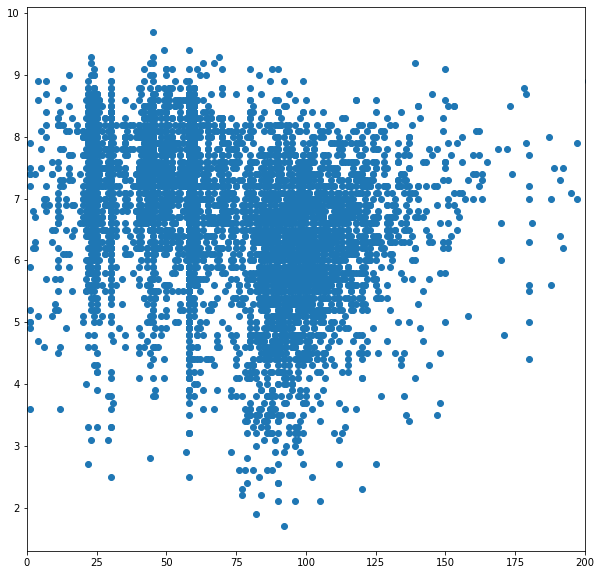

In [50]:
# convert strings to numeric values
df['runtime'] = pd.to_numeric(df['runtime'])

# scatter plot
plt.figure(figsize=(10,10))
plt.scatter(df['runtime'], df['rating'])
plt.xlim([0,200])
plt.show()

### Pearson’s Correlation Coefficient

In [51]:
coef_, p_value = pearsonr(df['runtime'], df['rating'])
print('Variable {:<16} | Coefficient {:<10.5f} | p-value {:.5f}'.format('runtime', coef_, p_value))

Variable runtime          | Coefficient -0.13036   | p-value 0.00000


It seems that there is no correlation between 'rating' and 'runtime' in the scatter plot but p-value shows the variable 'runtime' is significant. So, we decide to use 'runtime' for modeling. 

## Text Analytics

In [52]:
# remove any funky characters with a blank
df_copy['summary'] = df_copy['summary'].str.replace('[^A-z ]','').str.replace(' +',' ').str.strip()
df_copy['summary'].head()

0    Lucifer Morningstar bored from his sulking lif...
1    With the abandoned walled city of Las Vegas ov...
2    Michael Douglas plays an actor who made it big...
3    Ross Geller Rachel Green Monica Geller Joey Tr...
4    In the small fictional town of Edda coming of ...
Name: summary, dtype: object

In [53]:
# make everything lowercase
df_copy['summary'] = df_copy['summary'].str.lower()
print(df_copy['summary'][0])
print(df_copy['summary'][1])
print(df_copy['summary'][2])

lucifer morningstar bored from his sulking life in hell comes to live in los angeles while there he helps humanity with its miseries through his experience and telepathic abilities to bring peoples deepest desires and thoughts out of them while meeting with a detective in his nightclub lux a shootout involving him and the detective leads him to become an lapd consultant who tries to punish people for their crimes through law and justice ahmetkozan
with the abandoned walled city of las vegas overrun with zombies after a disastrous government fault the billionaire casino magnate bly tanaka realises that he has left something in sin city million to be more precise for the time being his mountains of cash are safe behind his impenetrable casino vault however the us president plans to nuke the entire city in less than hours now tanaka is willing to pay million to the decorated former mercenary scott ward and his handpicked team to retrieve the money before the bomb obliterates the city inde

In [54]:
# let's remove some of the stop words
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords') # download stopwords
print(stopwords.words('english'))

stop = stopwords.words('english') # let's see what they are

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\newbm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [55]:
# adds a space between selected words
df_copy['summary'] = df_copy['summary'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) 
df_copy.head()

,startYear,runtime,type,language,summary,rating,Sci-Fi,Biography,Drama,Adventure,...,Crime,Documentary,Animation,Romance,Family,Comedy,Fantasy,Horror,Thriller,genre_others
0,10s,42,tvSeries,English,lucifer morningstar bored sulking life hell co...,8.1,0,0,1,0,...,1,0,0,0,0,0,1,0,0,0
1,20s,148,movie,English,abandoned walled city las vegas overrun zombie...,5.8,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,10s,30,tvSeries,English,michael douglas plays actor made big long time...,8.2,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,90s,22,tvSeries,English,ross geller rachel green monica geller joey tr...,8.9,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,20s,45,tvSeries,Others,small fictional town edda coming age people fo...,7.5,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0


In [56]:
# seperate ratings into three groups
rating_7_10=df_copy[(df_copy['rating']>=7)&(df_copy['rating']<=10)]
rating_4_7=df_copy[(df_copy['rating']>=4)&(df_copy['rating']<7)]
rating_0_4=df_copy[(df_copy['rating']>=0)&(df_copy['rating']<4)]

In [57]:
df_copy['summary']

0       lucifer morningstar bored sulking life hell co...
1       abandoned walled city las vegas overrun zombie...
2       michael douglas plays actor made big long time...
3       ross geller rachel green monica geller joey tr...
4       small fictional town edda coming age people fo...
                              ...                        
5991    aftermath school shooting yearold maja norberg...
5995    rosa ambitious intelligent college student try...
5996    daughter arrives home holidays quinn forced pu...
5998    kate experiences force nature tully meet teens...
5999                                                     
Name: summary, Length: 5269, dtype: object

In [58]:
# select top50 words for each group
rating_7_10_top50=pd.Series(' '.join(rating_7_10['summary']).split()).value_counts()[:50]
rating_4_7_top50=pd.Series(' '.join(rating_4_7['summary']).split()).value_counts()[:50]
rating_0_4_top50=pd.Series(' '.join(rating_0_4['summary']).split()).value_counts()[:50]

In [59]:
# convert them to dataframes
rating_7_10_top50 = pd.DataFrame(rating_7_10_top50)
rating_4_7_top50 = pd.DataFrame(rating_4_7_top50)
rating_0_4_top50 = pd.DataFrame(rating_0_4_top50)

In [60]:
# renames columns
rating_7_10_top50.reset_index(inplace=True)
rating_7_10_top50.columns = ['words','fre']
rating_4_7_top50.reset_index(inplace=True)
rating_4_7_top50.columns = ['words','fre']
rating_0_4_top50.reset_index(inplace=True)
rating_0_4_top50.columns = ['words','fre']

### Most common words

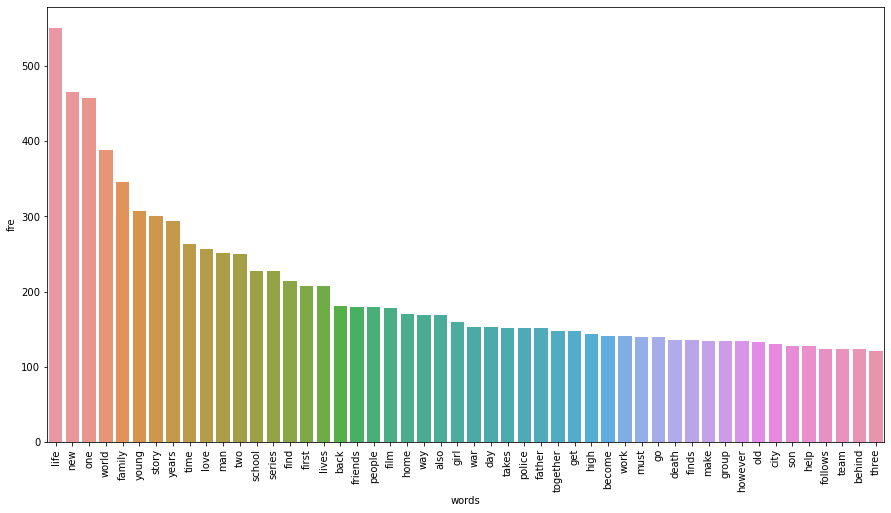

In [61]:
# show a plot of top50 words for rating 7 to 10
plt.figure(figsize=(15,8))
ax = sns.barplot(x=rating_7_10_top50['words'], y=rating_7_10_top50['fre'], data=rating_7_10_top50)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

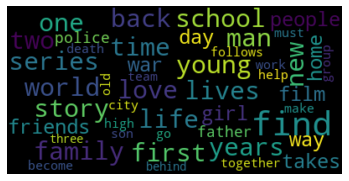

In [62]:
from wordcloud import WordCloud

# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(rating_7_10_top50['words']))

# # Display the generated image:

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(' '.join(rating_7_10_top50['words']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

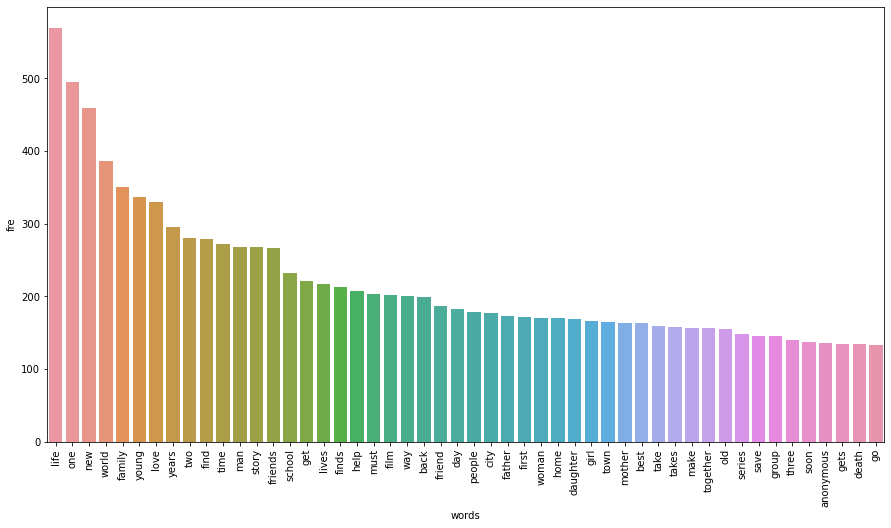

In [63]:
# show a plot of top50 words for rating 4 to 7
plt.figure(figsize=(15,8))
ax = sns.barplot(x=rating_4_7_top50['words'], y=rating_4_7_top50['fre'], data=rating_4_7_top50)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

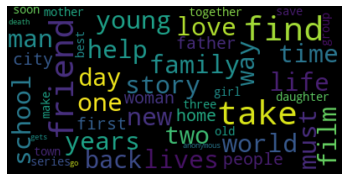

In [64]:
# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(rating_4_7_top50['words']))

# # Display the generated image:

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(' '.join(rating_4_7_top50['words']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

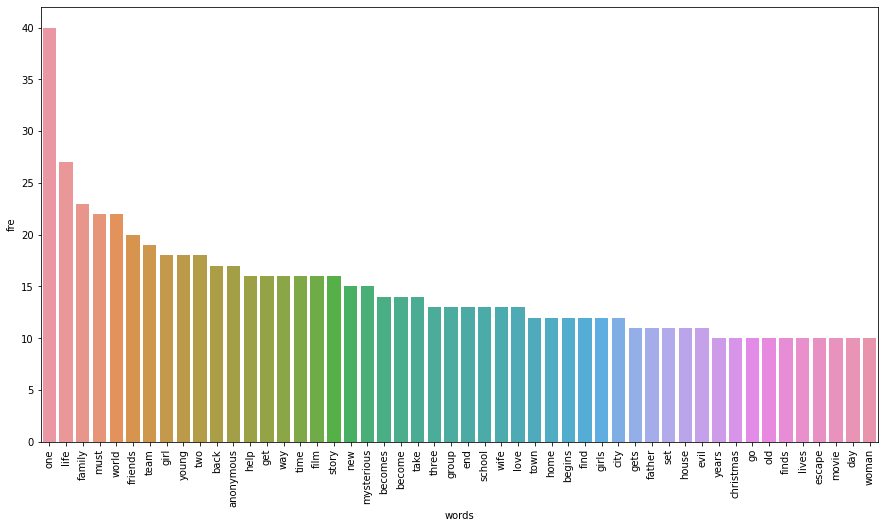

In [65]:
# show a plot of top50 words for rating 0 to 4
plt.figure(figsize=(15,8))
ax = sns.barplot(x=rating_0_4_top50['words'], y=rating_0_4_top50['fre'], data=rating_0_4_top50)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
plt.show()

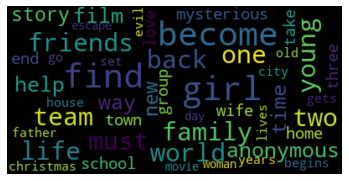

In [66]:
# Generate a word cloud image
wordcloud = WordCloud().generate(' '.join(rating_0_4_top50['words']))

# # Display the generated image:

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(' '.join(rating_0_4_top50['words']))
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

The variable 'summary' doesn't give us interesting characteristics for each group. It's better not to use this variable for modeling. So, we remove this variable. 

In [67]:
df.drop('summary', axis=1, inplace=True)

## Correlation Analysis

In [68]:
df_copy = df.copy()

cate_col = ['startYear','type','language']

class_le = LabelEncoder()

for col in cate_col:
    df_copy[col] = class_le.fit_transform(df_copy[col].values)

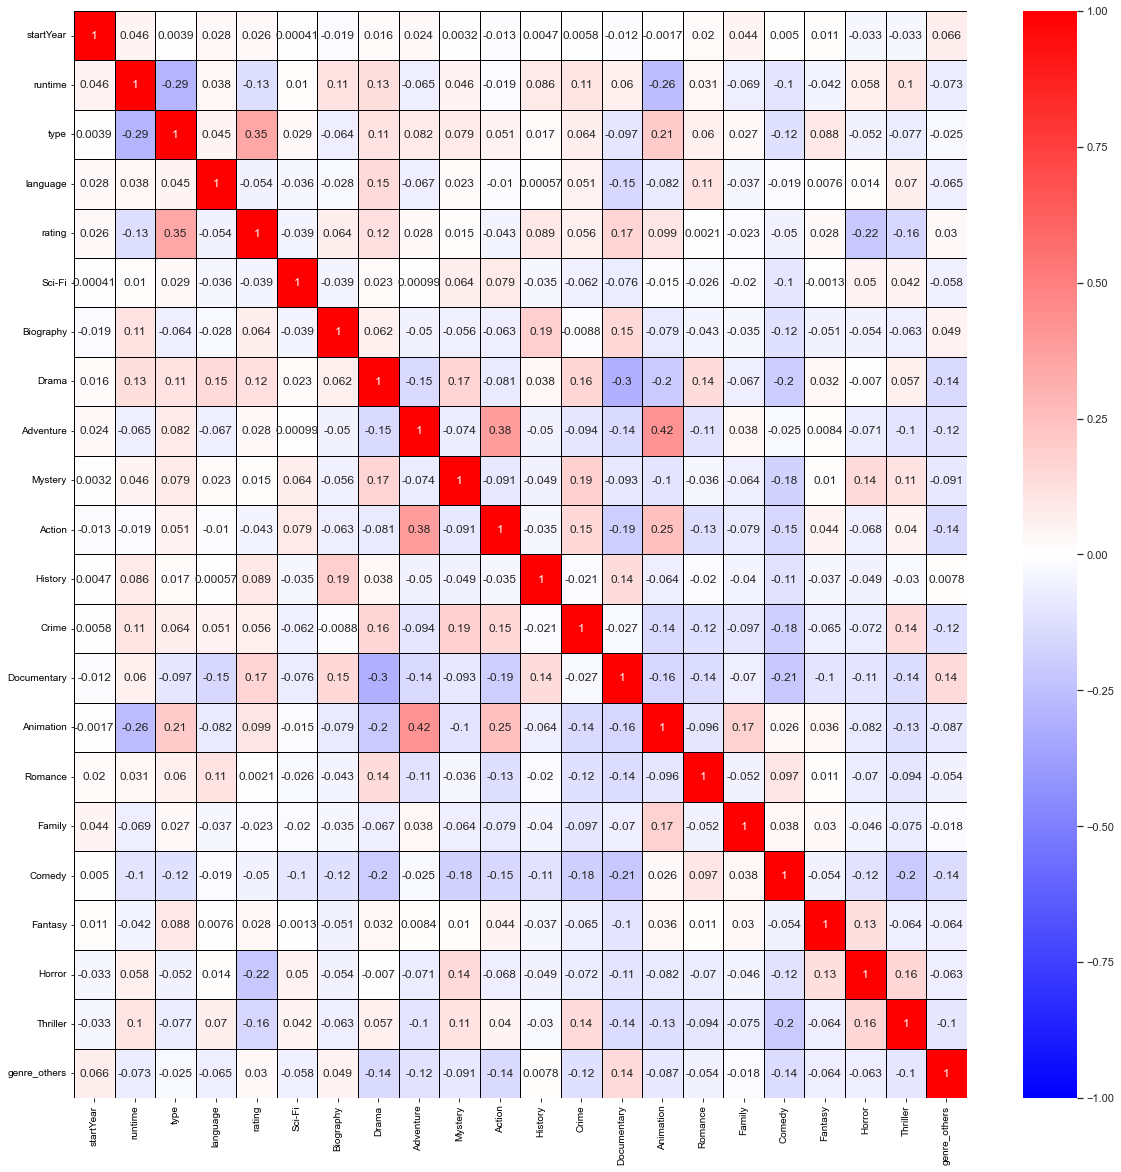

In [69]:
%matplotlib inline
 
fig, ax = plt.subplots(figsize=(20,20))
sns.set(font_scale=1)
sns.heatmap(df_copy.corr(), annot=True, vmin=-1, vmax=1, center=0, cmap='bwr', linewidths=1, linecolor='black', ax=ax)#, mask=matrix)
plt.show()

In [70]:
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = df_copy.columns

In [71]:
df_copy.head()

,startYear,runtime,type,language,rating,Sci-Fi,Biography,Drama,Adventure,Mystery,...,Crime,Documentary,Animation,Romance,Family,Comedy,Fantasy,Horror,Thriller,genre_others
0,1,42,3,0,8.1,0,0,1,0,0,...,1,0,0,0,0,0,1,0,0,0
1,2,148,1,0,5.8,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2,1,30,3,0,8.2,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
3,3,22,3,0,8.9,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
4,2,45,3,3,7.5,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0


In [72]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF dataframe
vif_data = pd.DataFrame()
df_copy.drop('rating', axis=1, inplace=True)
vif_data["feature"] = df_copy.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(df_copy.values, i)
                          for i in range(len(df_copy.columns))]
  
print(vif_data)

         feature       VIF
0      startYear  4.053100
1        runtime  3.473835
2           type  3.591542
3       language  1.697485
4         Sci-Fi  1.080927
5      Biography  1.142042
6          Drama  2.283375
7      Adventure  1.613042
8        Mystery  1.241573
9         Action  1.644509
10       History  1.116619
11         Crime  1.465827
12   Documentary  1.595338
13     Animation  1.662646
14       Romance  1.263740
15        Family  1.127694
16        Comedy  1.677628
17       Fantasy  1.119906
18        Horror  1.189431
19      Thriller  1.271453
20  genre_others  1.252939


# Modeling

## Creating dummy variables

In [73]:
dummy_col = ['startYear', 'type', 'language']

for col in dummy_col:
    df = pd.concat([df, pd.get_dummies(df[col], prefix=col, prefix_sep='_')], axis=1).drop(col,axis=1)
    
print(df.shape)
df.head()    

(6000, 33)


,runtime,rating,Sci-Fi,Biography,Drama,Adventure,Mystery,Action,History,Crime,...,startYear_~80s,type_Others,type_movie,type_tvEpisode,type_tvSeries,language_English,language_Japanese,language_Korean,language_Others,language_Spanish
0,42,8.1,0,0,1,0,0,0,0,1,...,0,0,0,0,1,1,0,0,0,0
1,148,5.8,0,0,0,0,0,1,0,1,...,0,0,1,0,0,1,0,0,0,0
2,30,8.2,0,0,1,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
3,22,8.9,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
4,45,7.5,0,0,1,0,0,1,0,0,...,0,0,0,0,1,0,0,0,1,0


In [74]:
Y = df['rating']
X = df.drop('rating', axis=1)
print(Y.shape)
print(X.shape)

(6000,)
(6000, 32)


## Normalization

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    shuffle = True,
                                                    random_state = 1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4800, 32) (1200, 32) (4800,) (1200,)


In [76]:
# Min/Max Scaling
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [77]:
tmp = pd.DataFrame(X_train)
tmp.describe()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
count,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,...,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000,4800.000000
mean,0.086708,0.033750,0.043125,0.414167,0.118750,0.071875,0.173125,0.034375,0.152292,0.158333,...,0.017083,0.092500,0.440625,0.103750,0.363125,0.565417,0.062708,0.046458,0.259583,0.065833
std,0.055357,0.180604,0.203160,0.492629,0.323528,0.258308,0.378395,0.182209,0.359341,0.365091,...,0.129595,0.289761,0.496514,0.304968,0.480951,0.495754,0.242463,0.210497,0.438452,0.248016
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.051643,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.075117,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
75%,0.112676,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
X_train = pd.DataFrame(X_train)
X_train.columns = X.columns
X_train.head()

,runtime,Sci-Fi,Biography,Drama,Adventure,Mystery,Action,History,Crime,Documentary,...,startYear_~80s,type_Others,type_movie,type_tvEpisode,type_tvSeries,language_English,language_Japanese,language_Korean,language_Others,language_Spanish
0,0.064554,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.016432,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
2,0.007042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,0.048122,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.120892,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [79]:
X_test = pd.DataFrame(X_test)
X_test.columns = X.columns
X_test.head()

,runtime,Sci-Fi,Biography,Drama,Adventure,Mystery,Action,History,Crime,Documentary,...,startYear_~80s,type_Others,type_movie,type_tvEpisode,type_tvSeries,language_English,language_Japanese,language_Korean,language_Others,language_Spanish
0,0.057512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.133803,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.039906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.133803,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.039906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


## Linear Regression

In [80]:
reg = LinearRegression().fit(X_train, y_train)
train_preds_LR = reg.predict(X_train) 
test_preds_LR = reg.predict(X_test) 

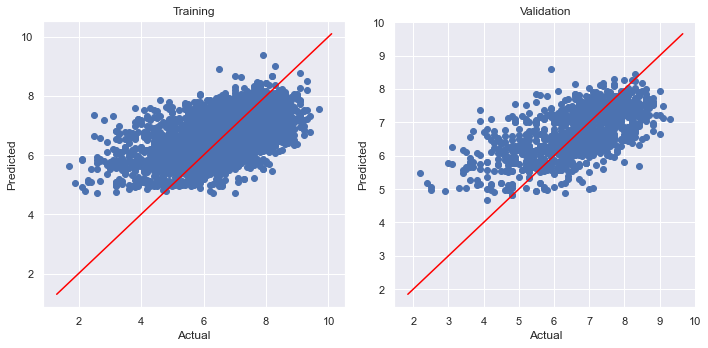

In [81]:
fig, axes = plt.subplots(1,2, figsize=(10,5)) 

axes[0].scatter(x=y_train, y=train_preds_LR)
axes[0].set_xlabel("Actual", fontsize=12)
axes[0].set_ylabel("Predicted",  fontsize=12)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=test_preds_LR) 
axes[1].set_xlabel("Actual", fontsize=12)
axes[1].set_ylabel("Predicted",  fontsize=12)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

fig.tight_layout()
plt.show()

In [82]:
# train
mse_value = mean_squared_error(y_train, train_preds_LR)
reg_rmse = np.sqrt(mse_value)
print('RMSE:', reg_rmse)
print('R-Squared', r2_score(y_train, train_preds_LR))

RMSE: 0.9849117751700679
R-Squared 0.3355073878363314


In [83]:
# test
mse_value = mean_squared_error(y_test, test_preds_LR)
reg_rmse = np.sqrt(mse_value)
print('RMSE:', reg_rmse)
print('R-Squared', r2_score(y_test, test_preds_LR))

RMSE: 0.9566007896147201
R-Squared 0.38035194910017056


## ElasticNet

In [84]:
elastic = ElasticNet()
params_elastic = {'alpha': [10,7,5,3,1,0.1,0.01,0.001,0.0001,0] , 'l1_ratio': [0, 0.01, 0.1, 0.5, 1]}
elastic_GS = GridSearchCV(elastic, param_grid=params_elastic, cv=5,  verbose = 3, n_jobs=-1)
elastic_GS.fit(X_train,y_train)
print(elastic_GS.best_params_)
print(elastic_GS.best_estimator_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'alpha': 0.0001, 'l1_ratio': 0}
ElasticNet(alpha=0.0001, l1_ratio=0)


In [85]:
elastic = ElasticNet(alpha=0.0001, l1_ratio=0)
elastic.fit(X_train, y_train)
train_preds_elastic = elastic.predict(X_train)
test_preds_elastic = elastic.predict(X_test)

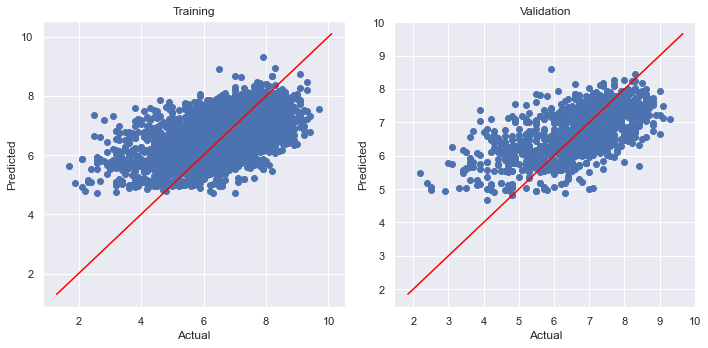

In [86]:
fig, axes = plt.subplots(1,2, figsize=(10,5)) 

axes[0].scatter(x=y_train, y=train_preds_elastic)
axes[0].set_xlabel("Actual", fontsize=12)
axes[0].set_ylabel("Predicted",  fontsize=12)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=test_preds_elastic) 
axes[1].set_xlabel("Actual", fontsize=12)
axes[1].set_ylabel("Predicted",  fontsize=12)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

fig.tight_layout()
plt.show()

In [87]:
# train
mse_value = mean_squared_error(y_train, train_preds_elastic)
elastic_rmse = np.sqrt(mse_value)
print('RMSE:', elastic_rmse)
print('R-Squared', r2_score(y_train, train_preds_elastic))

RMSE: 0.9849165802076512
R-Squared 0.3355009041697852


In [88]:
# test
mse_value = mean_squared_error(y_test, test_preds_elastic)
elastic_rmse = np.sqrt(mse_value)
print('RMSE:', elastic_rmse)
print('R-Squared', r2_score(y_test, test_preds_elastic))

RMSE: 0.9566781624824815
R-Squared 0.3802517068964223


## KNN Regressor

In [89]:
knn = KNeighborsRegressor()
params_knn = [{'weights': ['uniform', 'distance'], 'n_neighbors': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]}]
knn_GS = GridSearchCV(knn, param_grid=params_knn, cv=5,  verbose = 3, n_jobs=-1)
knn_GS.fit(X_train,y_train)
print(knn_GS.best_params_)
print(knn_GS.best_estimator_)

Fitting 5 folds for each of 22 candidates, totalling 110 fits
{'n_neighbors': 20, 'weights': 'uniform'}
KNeighborsRegressor(n_neighbors=20)


In [90]:
knn = KNeighborsRegressor(n_neighbors=20)
knn.fit(X_train, y_train)
train_preds_knn = knn.predict(X_train)
test_preds_knn = knn.predict(X_test)

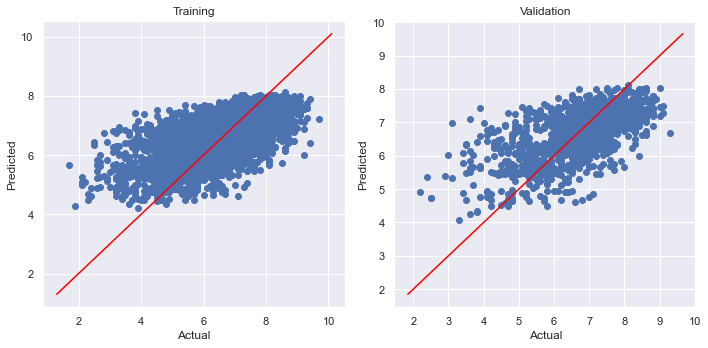

In [91]:
fig, axes = plt.subplots(1,2, figsize=(10,5)) 

axes[0].scatter(x=y_train, y=train_preds_knn)
axes[0].set_xlabel("Actual", fontsize=12)
axes[0].set_ylabel("Predicted",  fontsize=12)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=test_preds_knn) 
axes[1].set_xlabel("Actual", fontsize=12)
axes[1].set_ylabel("Predicted",  fontsize=12)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

fig.tight_layout()
plt.show()

In [92]:
# train
mse_value = mean_squared_error(y_train, train_preds_knn)
knn_rmse = np.sqrt(mse_value)
print('RMSE:', knn_rmse)
print('R-Squared', r2_score(y_train, train_preds_knn))

RMSE: 0.9142192536530829
R-Squared 0.4274726682940557


In [93]:
# test
mse_value = mean_squared_error(y_test, test_preds_knn)
knn_rmse = np.sqrt(mse_value)
print('RMSE:', knn_rmse)
print('R-Squared', r2_score(y_test, test_preds_knn))

RMSE: 0.9445419083696958
R-Squared 0.39587601050941257


## Gradient Boosting Regressor

In [94]:
GBR = GradientBoostingRegressor()
param_GBR = {'learning_rate': [0.01,0.03,0.05,0.07,0.1,0.2],
              'n_estimators' : [100,500,1000],
              'max_depth'    : [4,6,8,10]
              }
GBR_GS = GridSearchCV(GBR, param_grid=param_GBR, cv=5,  verbose = 3, n_jobs=-1)
GBR_GS.fit(X_train,y_train)
print(GBR_GS.best_params_)
print(GBR_GS.best_estimator_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
{'learning_rate': 0.03, 'max_depth': 4, 'n_estimators': 500}
GradientBoostingRegressor(learning_rate=0.03, max_depth=4, n_estimators=500)


In [95]:
GBR = GradientBoostingRegressor(learning_rate=0.03, max_depth=4, n_estimators=500)
GBR.fit(X_train, y_train)
train_preds_GBR = GBR.predict(X_train)
test_preds_GBR = GBR.predict(X_test)

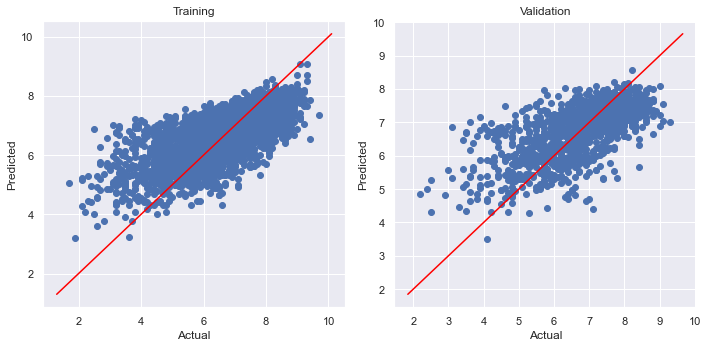

In [96]:
fig, axes = plt.subplots(1,2, figsize=(10,5)) 

axes[0].scatter(x=y_train, y=train_preds_GBR)
axes[0].set_xlabel("Actual", fontsize=12)
axes[0].set_ylabel("Predicted",  fontsize=12)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=test_preds_GBR) 
axes[1].set_xlabel("Actual", fontsize=12)
axes[1].set_ylabel("Predicted",  fontsize=12)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

fig.tight_layout()
plt.show()

In [97]:
# train
mse_value = mean_squared_error(y_train, train_preds_GBR)
GBR_rmse = np.sqrt(mse_value)
print('RMSE:', GBR_rmse)
print('R-Squared', r2_score(y_train, train_preds_GBR))

RMSE: 0.8505400303790775
R-Squared 0.5044528142444851


In [98]:
# test
mse_value = mean_squared_error(y_test, test_preds_GBR)
GBR_rmse = np.sqrt(mse_value)
print('RMSE:', GBR_rmse)
print('R-Squared', r2_score(y_test, test_preds_GBR))

RMSE: 0.9296183435747937
R-Squared 0.4148152665959669


## Multilayer Perceptron Regressor

In [99]:
mlp = MLPRegressor()
param_mlp = {
    'hidden_layer_sizes': [(150,100,50), (120,80,40), (100,50,30)],
    'max_iter': [50, 100],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}
mlp_GS = GridSearchCV(mlp, param_grid=param_mlp, cv=5,  verbose = 3, n_jobs=-1)
mlp_GS.fit(X_train,y_train)
print(mlp_GS.best_params_)
print(mlp_GS.best_estimator_)

Fitting 5 folds for each of 96 candidates, totalling 480 fits
{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (120, 80, 40), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'adam'}
MLPRegressor(activation='tanh', alpha=0.05, hidden_layer_sizes=(120, 80, 40),
             max_iter=100)


In [105]:
mlp = MLPRegressor(activation='tanh', alpha=0.05, hidden_layer_sizes=(120, 80, 40),max_iter=100)
mlp.fit(X_train, y_train)
train_preds_mlp = mlp.predict(X_train)
test_preds_mlp = mlp.predict(X_test)

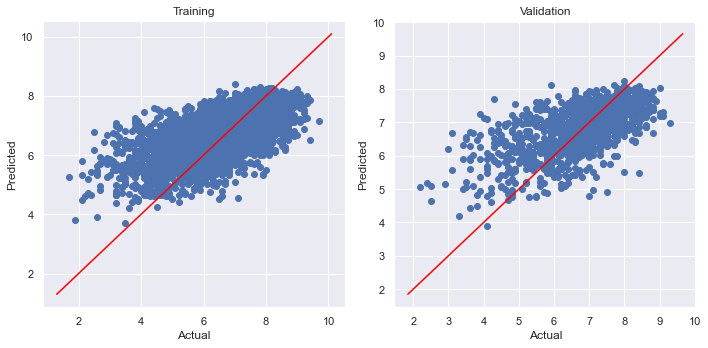

In [106]:
fig, axes = plt.subplots(1,2, figsize=(10,5)) 

axes[0].scatter(x=y_train, y=train_preds_mlp)
axes[0].set_xlabel("Actual", fontsize=12)
axes[0].set_ylabel("Predicted",  fontsize=12)
axes[0].set_title("Training")
# add 45 deg line
x = np.linspace(*axes[0].get_xlim())
axes[0].plot(x, x, color='red')
# Validation Results
axes[1].scatter(x=y_test, y=test_preds_mlp) 
axes[1].set_xlabel("Actual", fontsize=12)
axes[1].set_ylabel("Predicted",  fontsize=12)
axes[1].set_title("Validation")
# add 45 deg line
x = np.linspace(*axes[1].get_xlim())
axes[1].plot(x, x, color='red')

fig.tight_layout()
plt.show()

In [107]:
# train
mse_value = mean_squared_error(y_train, train_preds_mlp)
mlp_rmse = np.sqrt(mse_value)
print('RMSE:', mlp_rmse)
print('R-Squared', r2_score(y_train, train_preds_mlp))

RMSE: 0.9091185468256472
R-Squared 0.4338434539767999


In [108]:
# test
mse_value = mean_squared_error(y_test, test_preds_mlp)
mlp_rmse = np.sqrt(mse_value)
print('RMSE:', mlp_rmse)
print('R-Squared', r2_score(y_test, test_preds_mlp))

RMSE: 0.9513185992242538
R-Squared 0.3871762424969437


# Model Evaluation

In [109]:
RMSE=[reg_rmse,elastic_rmse,knn_rmse,GBR_rmse,mlp_rmse]
col={'Root Mean Square Error': RMSE}
models=['Linear Regression','Elastic Net', 'KNN','Boosted Tree','Neural Network']
dfplot=pd.DataFrame(data=col,index=models)
dfplot

,Root Mean Square Error
Linear Regression,0.956601
Elastic Net,0.956678
KNN,0.944542
Boosted Tree,0.929618
Neural Network,0.951319


Based on the above graph, we decided that the boosted tree was the best model.

# **Recommendations**
---
* Contents from South Korea have the highest average ratings but the number of contents is relatively smaller. Netflix should increase the number of contents from South Korea. 

* Since the genres 'history' and 'biography' have relatively higher ratings, Netflix needs to increase the number of contents regarding the two genres, while decreasing the contents in 'horror' and 'thriller'.

* People are willing to watch and give the older contents higher ratings if they have good reputations over time. Therefore, Netflix needs to keep updating the existing contents, extending and managing the contracts.